# PSF Photometry in Crowded Fields with Photutils

##### This notebook exemplifies the use of photutils.psf to perform point spread function (PSF) photometry in crowded fields simulated assuming that the PSF of the stars has a Gaussian shape

## Create an artificial image

##### Let's create an artificial image using photutils.datasets functionalities

In [1]:
from photutils.datasets import make_random_gaussians
from photutils.datasets import make_noise_image
from photutils.datasets import make_gaussian_sources

num_sources = 150
min_flux = 500
max_flux = 5000
min_xmean = 16
max_xmean = 240
sigma_psf = 2.0
starlist = make_random_gaussians(num_sources, [min_flux, max_flux],
                                 [min_xmean, max_xmean],
                                 [min_xmean, max_xmean],
                                 [sigma_psf, sigma_psf],
                                 [sigma_psf, sigma_psf],
                                 random_state=123)
shape = (256, 256)
image = (make_gaussian_sources(shape, starlist) +
         make_noise_image(shape, type='poisson', mean=6., random_state=123) + 
         make_noise_image(shape, type='gaussian', mean=0., stddev=2., random_state=123))
starlist

flux,x_mean,y_mean,x_stddev,y_stddev,theta
float64,float64,float64,float64,float64,float64
3634.11133519,53.1700860624,19.6719157162,2.0,2.0,1.54768051313
1787.62700728,190.943538112,177.545297995,2.0,2.0,2.42073188884
1520.83154104,80.1842021473,17.7332031642,2.0,2.0,1.75929157855
2980.91646087,84.6492247458,35.0001901477,2.0,2.0,4.13220116374
3737.61036404,165.018568238,66.5116439408,2.0,2.0,2.03714454696
2403.97907056,40.9518464401,212.027895588,2.0,2.0,4.73998224779
4913.43889273,164.931428532,97.4410952292,2.0,2.0,0.713198573693
3581.73382363,214.879921559,136.951025488,2.0,2.0,4.8717604856
2664.19355668,171.973724085,143.255119895,2.0,2.0,3.68133067859


## Initialize instances for the DAOPhotPSFPhotometry object

##### In order to initiliaze a DAOPhotPSFPhotometry object, we have to load some other objects which will be used to perform PSF photometry. More precisely, the required parts are:  a fitter (e.g., from astropy.fitting), a source detection (e.g., DAOStarFinder or IRAFStarFinder, from photutils.detection), a grouping functionality (e.g., DAOGroup from photutils.psf), a background estimator (e.g. MedianBackground or MMMBackground, from photutils.background), and a PSF model (e.g., IntegratedGaussianPRF from photutils.psf).

In [2]:
from photutils.detection import DAOStarFinder, IRAFStarFinder
from photutils.psf import DAOGroup
from photutils.psf import IntegratedGaussianPRF
from photutils.background import MMMBackground
from photutils.background import MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm

bkgrms = MADStdBackgroundRMS()

std = bkgrms(image)

iraffind = IRAFStarFinder(threshold=3.5*std,
                          fwhm=sigma_psf*gaussian_sigma_to_fwhm,
                          minsep_fwhm=0.01, roundhi=5.0, roundlo=-5.0,
                          sharplo=0.0, sharphi=2.0)

daogroup = DAOGroup(2.0*sigma_psf*gaussian_sigma_to_fwhm)

mmm_bkg = MMMBackground()

psf_model = IntegratedGaussianPRF(sigma=sigma_psf)

fitter = LevMarLSQFitter()

#### It's worth noting that the values of the IRAFStarFinder parameters were chosen purely empirically and optimum values may vary according to the data.

## Perform photometry

##### To perform PSF photometry, we need first to initialize a DAOPhotPSFPhotometry object by passing along the objects loaded in the previous cell. Similarly to DAOGroup and DAOStarFinder, DAOPhotPSFPhotometry class was designed such that its objetcs are callable, which means that one can call them in the same fashion as calling a function. This, in fact, will call the appropriate method to perform photometry. 

In [3]:
from photutils.psf import DAOPhotPSFPhotometry

daophot_photometry = DAOPhotPSFPhotometry(finder=iraffind, group_maker=daogroup,
                                          bkg_estimator=mmm_bkg, psf_model=psf_model,
                                          fitter=LevMarLSQFitter(),
                                          niters=2, fitshape=(11,11))
result_tab, residual_image = daophot_photometry(image)

##### This warning, raised by LevMarLSQFitter, lets us know that some sources (or groups of sources) may not be fitted successfully. Let's check the residuals to see which sources were not fitted correctly.

## Plot original and residual images

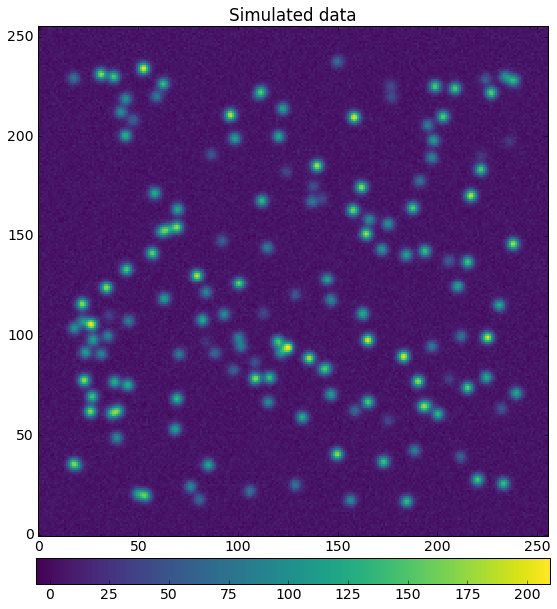

In [4]:
import numpy as np
%matplotlib inline
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams['image.cmap'] = 'viridis'
rcParams['image.aspect'] = 1  # to get images with square pixels
rcParams['figure.figsize'] = (20,10)
rcParams['image.interpolation'] = 'nearest'
rcParams['image.origin'] = 'lower'
rcParams['font.size'] = 14

plt.imshow(image)
plt.title('Simulated data')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

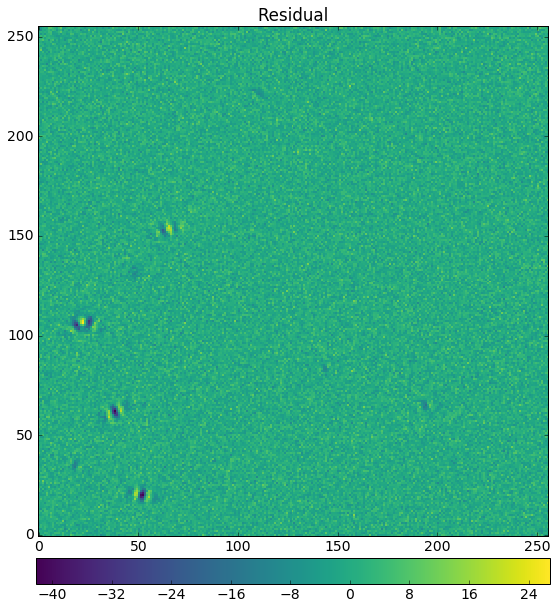

In [5]:
plt.imshow(residual_image)
plt.title('Residual')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [6]:
result_tab.sort('id')
result_tab

x_0,y_0,flux_0,id,group_id,iter_detected,x_fit,y_fit,flux_fit
,,,,,,,,
float64,float64,float64,int32,int32,int64,float64,float64,float64
156.210680144,17.2920300761,2154.43590416,1,1,1,156.260790783,17.3845228606,2333.02304936
55.3471344509,19.5960795013,328.662322023,1,1,2,55.8822249494,18.9936831457,645.064860366
47.932544679,20.9376862499,772.807199366,2,1,2,47.5522100497,20.9767687677,1138.14170948
184.281235414,16.8198056428,3176.28232645,2,2,1,184.368144648,16.8000539086,3430.1783463
80.0772903582,17.8620186588,1574.77229645,3,3,1,80.1613815737,17.7411096538,1585.39273658
21.2795516589,33.7934993479,183.709894092,3,2,2,21.9527215261,33.6105827472,298.307633228
105.37537507,21.9477952351,1711.8849188,4,4,1,51.920074269,20.015846639,4949.69025084
14.8701904935,36.8249962237,68.2748242776,4,3,2,79.065531002,35.1940490796,76.5471043112


## Photometry with fixed positions
##### Now, let's perform photometry for the case that star positions are held fixed and one is interested only in fitting the flux.
##### This is useful  when all stellar positions are known a priori with a very high accuracy. In this case, the parameter space is reduced to the 1D real space, making the optimizer much more likely to find the global optimum. 

In [7]:
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True

In [8]:
positions = starlist['x_mean', 'y_mean']
positions['x_mean'].name = 'x_0'
positions['y_mean'].name = 'y_0'

In [9]:
daophot_photometry = DAOPhotPSFPhotometry(group_maker=daogroup,
                                          bkg_estimator=mmm_bkg, psf_model=psf_model,
                                          fitter=LevMarLSQFitter(), fitshape=(11,11))
result_tab, residual_image = daophot_photometry(image=image, positions=positions)

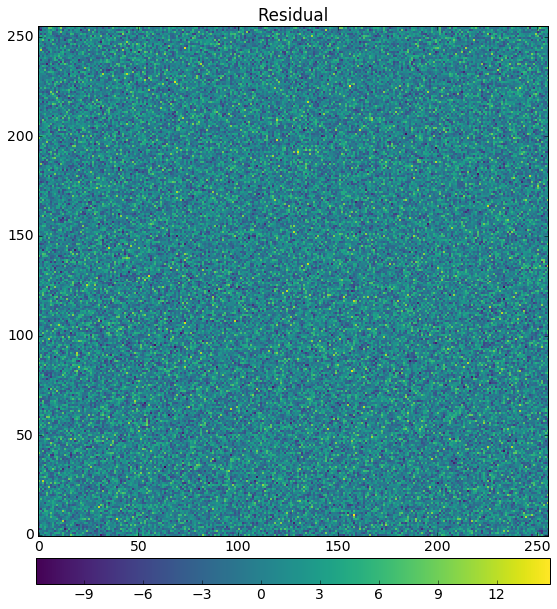

In [10]:
plt.imshow(residual_image)
plt.title('Residual')
plt.colorbar(orientation='horizontal', fraction=0.046, pad=0.04)

In [11]:
result_tab.sort('id')
print(result_tab)

     x_0           y_0          flux_0    ...     y_fit        flux_fit  
                                          ...                            
------------- ------------- ------------- ... ------------- -------------
53.1700860624 19.6719157162 4832.77836158 ... 19.6719157162 3651.24214071
80.1842021473 17.7332031642  1557.5909964 ... 177.545297995 1791.19379085
84.6492247458 35.0001901477 2797.92176276 ... 17.7332031642 1584.75003212
40.9518464401 212.027895588 2596.33669111 ... 35.0001901477 3006.43930365
164.931428532 97.4410952292 4644.21498795 ... 66.5116439408 3819.81949027
171.973724085 143.255119895 2473.47148345 ... 212.027895588 2426.82657558
142.703808275 82.8069681031 3929.09183628 ... 97.4410952292 5007.18937119
 35.018532555 109.772416412 818.010605604 ... 136.951025488 3646.15061908
146.518323681 117.491919098 2171.90254798 ... 143.255119895   2671.207235
198.524989448 224.846548185 3542.15889236 ... 66.5037927085 2265.14924342
          ...           ...           

##### Now, let's create a scatter plot to compare the estimated and the ground truth fluxes 

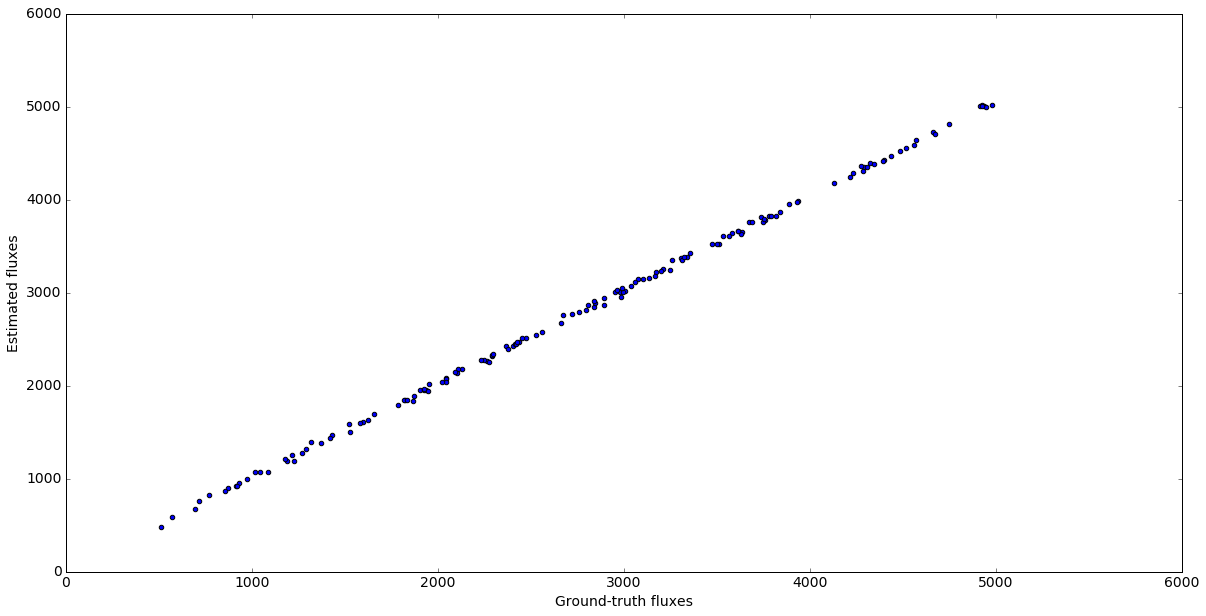

In [12]:
plt.scatter(starlist['flux'], result_tab['flux_fit'])
plt.xlabel('Ground-truth fluxes')
plt.ylabel('Estimated fluxes')

#### Let's print the linear correlation coefficient and the root mean squared error (rmse) which are often used to check the correlation and the bias between two data sets 

In [13]:
print(np.corrcoef(starlist['flux'], result_tab['flux_fit'])[0][1])
print(np.sqrt(np.mean((starlist['flux'] - result_tab['flux_fit'])**2)))

0.999783761917
44.7227061855


#### A correlation coefficient of .999 means that the fitting process is very consistent, i.e., the fitter was able to correctly estimate most of the star fluxes. An RMSE of approximately 45 means that the fluxes estimates are biased, on average, by 45.

##### Now let's check how the relative error looks like as a function of the simulated flux

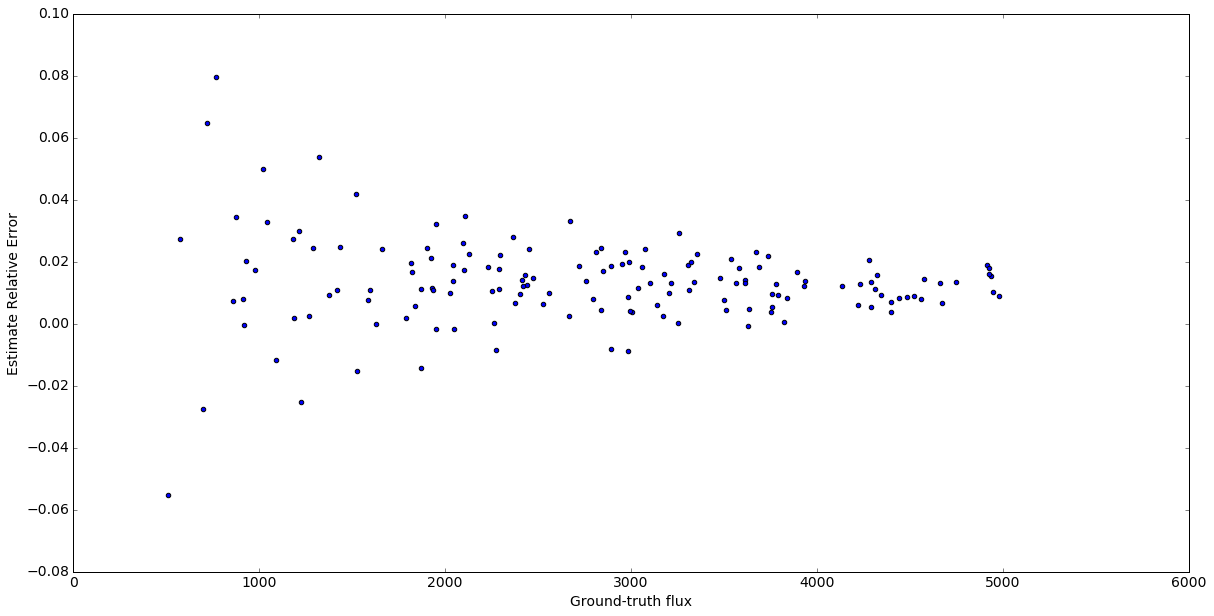

In [14]:
plt.scatter(starlist['flux'], (result_tab['flux_fit'] - starlist['flux'])/starlist['flux'])
plt.xlabel('Ground-truth flux')
plt.ylabel('Estimate Relative Error')

##### As expected, the relative error decreases as the flux increases. 